In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import tensorflow as tf
import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis as cfv
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator
import sys
import os
import json

In [412]:
nodes_els = nodes[elements]

A11 = np.array([[1,0],[0,1]])
A12 = np.array([[0,0],[0,0]])
A22 = np.array([[1,0.5],[0.5,1]])
A = np.concatenate([
    np.concatenate([A11,A12],axis=1),
    np.concatenate([A12,A22],axis=1)
],axis=0)

r = int(A.shape[-1]/2)
a = None
# a = np.roll(nodes_els[:,:,0],1,axis=1)*np.roll(nodes_els[:,:,1],2,axis=1) - np.roll(nodes_els[:,:,0],2,axis=1)*np.roll(nodes_els[:,:,1],1,axis=1)
b = (np.roll(nodes_els[:,:,1],1,axis=1) - np.roll(nodes_els[:,:,1],2,axis=1)).reshape(-1,3,1)
c = (np.roll(nodes_els[:,:,0],2,axis=1) - np.roll(nodes_els[:,:,0],1,axis=1)).reshape(-1,3,1)
Area = np.abs(np.matmul(nodes_els[:,:,0].reshape(-1,1,3),b))/2
B = np.concatenate([
    np.concatenate([b[:,i:i+1]*np.eye(r).reshape(1,r,r) for i in range(3)],-1),
    np.concatenate([c[:,i:i+1]*np.eye(r).reshape(1,r,r) for i in range(3)],-1)
],-2)/(2*Area)
B_T = np.transpose(B,(0,2,1))
K_els = np.matmul(np.matmul(B_T,A),B)*Area

In [14]:
def PlotMesh(nodes, boundaryNodes, elements,lineWidth=1):
    plt.figure(figsize=(10,10))
    plt.scatter(nodes[:,0],nodes[:,1])
    if elements.shape[1] == 4:
        for el in elements:
            plt.plot(nodes[[el[0],el[1],el[3],el[2],el[0]],0], nodes[[el[0],el[1],el[3],el[2],el[0]],1], 'k',linewidth=lineWidth)
    elif elements.shape[1] == 3:
        for el in elements:
            plt.plot(nodes[[el[0],el[1],el[2],el[0]],0], nodes[[el[0],el[1],el[2],el[0]],1], 'k',linewidth=lineWidth)
    plt.plot(nodes[boundaryNodes,0],nodes[boundaryNodes,1],'r',linewidth=lineWidth)
    plt.gca().set_aspect('equal', adjustable='box')
    # plt.show()

def GetK_el_triang(A,nodes):
    r = int(A.shape[0]/2)
    # a = np.roll(nodes[:,0],1)*np.roll(nodes[:,1],2) - np.roll(nodes[:,0],2)*np.roll(nodes[:,1],1)
    b = np.roll(nodes[:,1],1) - np.roll(nodes[:,1],2)
    c = np.roll(nodes[:,0],2) - np.roll(nodes[:,0],1)
    Area = np.abs(np.dot(nodes[:,0],b))/2
    B = np.concatenate([
        np.concatenate([b[i]*np.eye(r) for i in range(3)],1),
        np.concatenate([c[i]*np.eye(r) for i in range(3)],1)
    ],0)/(2*Area)
    return np.dot(np.dot(B.T,A),B)*Area


def GetK(nodes_els, A):
    r = int(A.shape[0]/2)
    b = (np.roll(nodes_els[:,:,1],1,axis=1) - np.roll(nodes_els[:,:,1],2,axis=1)).reshape(-1,3,1)
    c = (np.roll(nodes_els[:,:,0],2,axis=1) - np.roll(nodes_els[:,:,0],1,axis=1)).reshape(-1,3,1)
    Area = np.abs(np.matmul(nodes_els[:,:,0].reshape(-1,1,3),b))/2
    B = np.concatenate([
        np.concatenate([b[:,i:i+1]*np.eye(r).reshape(1,r,r) for i in range(3)],-1),
        np.concatenate([c[:,i:i+1]*np.eye(r).reshape(1,r,r) for i in range(3)],-1)
    ],-2)/(2*Area)
    B_T = np.transpose(B,(0,2,1))
    return np.matmul(np.matmul(B_T,A),B)*Area

def SolveFEM(nodes, elements, boundaryNodes, BCfunc, alpha, internalNodes, r, A, A_nl=False, l=None):
    if l is None:
        l = np.zeros((nodes.shape[0], r))
    if not A_nl:
        A_l = A

    # Assemble the global stiffness matrix
    K = np.zeros((nodes.shape[0]*r, nodes.shape[0]*r))
    for el in elements:
        el_idx = [[r*k+j for j in range(r)] for k in el]
        el_idx = np.concatenate(el_idx)
        nodes_el = tf.gather(nodes, indices=el)
        X_idx,Y_idx = np.meshgrid(el_idx,el_idx)
        if A_nl:
            A_l = A(l[el_idx])
        # print(A_l)
        K_el = GetK_el_triang(A_l,nodes_el)
        K[Y_idx,X_idx] += K_el

    # Apply Dirichlet BC
    l_BC = BCfunc(alpha*2*np.pi)
    bc_idx = [[r*i+j for j in range(r)] for i in boundaryNodes]
    bc_idx = np.concatenate(bc_idx)
    internal_idx = [[r*i+j for j in range(r)] for i in internalNodes]
    internal_idx = np.concatenate(internal_idx)

    f = - (K[:,bc_idx] @ l_BC.flatten().reshape(-1,1))

    K_BC = K[internal_idx,:][:,internal_idx]
    f = f[internal_idx]

    # Solve the system
    l_internal = np.linalg.solve(K_BC, f)
    n_CDOF = int(l_internal.shape[0]/r)
    l_internal = l_internal.reshape(n_CDOF, r)

    l[internalNodes,:] = l_internal
    l[boundaryNodes,:] = l_BC.reshape(-1,r)
    return l

def SolveFEM_itt(nodes, elements, boundaryNodes, BCfunc, alpha, internalNodes, r, A, tol=1e-8,show_err=False, max_iter=10):

    l_prev = SolveFEM(nodes, elements, boundaryNodes, BCfunc, alpha, internalNodes, r, A, A_nl=True, l=None)

    err = 1
    i = 1
    while err>tol and i<max_iter:
        l = SolveFEM(nodes, elements, boundaryNodes, BCfunc, alpha, internalNodes, r, A, A_nl=True, l=l_prev.copy())
        err = ((l-l_prev)**2).mean()
        if show_err:
            print(f'Iteration {i}; err = {err}')
        i+=1
        l_prev = l.copy()

    return l, i

def PlotFEMsolution(nodes, elements,l):
    if elements.shape[1] == 4:
        # Convert quadrlateral mesh to triangular mesh
        elements = np.concatenate([elements[:,:3],elements[:,1:]],0)

    # Create a Triangulation object
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)

    # Plotting
    r = l.shape[1]
    plt.figure(figsize=(6*r,5))
    for i in range(r):
        plt.subplot(1,r,i+1)
        plt.tricontourf(triangulation, l[:,i],10)
        plt.colorbar()
        # plt.scatter(nodes[:,0],nodes[:,1],s=1,c='k')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.gca().set_aspect('equal', adjustable='box')
    return 

def PlotFEMsoluttionDict(solution):
    nodes = np.array(solution['nodes'])
    elements = np.array(solution['elements'])
    l = np.array(solution['l'])
    PlotFEMsolution(nodes, elements,l)

In [4]:
def GenerateGeometry(p):
    g = cfg.Geometry()
    for i in range(p.shape[0]):
        g.point(list(p[i]))
    g.spline(list(range(p.shape[0]))+[0])
    g.surface([0])
    return g

def MeshSurface(g,elSize):
    mesh = cfm.GmshMesh(g)
    mesh.elType = 2       # Degrees of freedom per node.
    mesh.dofsPerNode = 1     # Factor that changes element sizes.
    mesh.elSizeFactor = elSize # Element size Factor
    nodes, edof, dofs, bdofs, elementmarkers = mesh.create()

    elements = edof-1
    boundaryNodes = np.array(bdofs[0])-1
    internalNodes = np.setdiff1d(np.arange(nodes.shape[0]), boundaryNodes)

    alpha = GetDistAlongBoundary(nodes,boundaryNodes)
    return nodes, elements, boundaryNodes, internalNodes, alpha

def GetRandomBCfuncAlpha(n_order=3, r=1):
    p = np.random.randn(2,n_order,r)
    BCfunc_unscaled = lambda alpha: np.array([[p[0,j,i]*np.cos((j+1)*alpha) + p[1,j,i]*np.sin((j+1)*alpha) for i in range(r)] for j in range(n_order)]).T.sum(axis=-1)
    alpha = np.linspace(0,2*np.pi,100)
    vals = BCfunc_unscaled(alpha)
    vals_max = np.max(vals)
    vals_min = np.min(vals)
    BCfunc = lambda alpha: (BCfunc_unscaled(alpha)-vals_min)/(vals_max-vals_min)*2-1
    return BCfunc

def SortBoundaryNodes(boundaryNodes,nodes):
    boundaryNodesSorted = [boundaryNodes[0]]
    boundaryNodesNotSorted = np.delete(boundaryNodes,0)
    for i in range(1,len(boundaryNodes)):
        idx = ((nodes[boundaryNodes[i]]-nodes[boundaryNodesNotSorted])**2).sum(axis=1).argmin()
        boundaryNodesSorted.append(boundaryNodesNotSorted[idx])
        boundaryNodesNotSorted = np.delete(boundaryNodesNotSorted,idx)
    return np.array(boundaryNodesSorted)

def GetDistAlongBoundary(nodes,boundaryNodes):
    ds = [0]+[np.sqrt(((nodes[boundaryNodes[i-1]]-nodes[boundaryNodes[i]])**2).sum()) for i in range(boundaryNodes.shape[0])]
    s = np.cumsum(ds)
    s = s[:-1]/s[-1]
    return s

def GetRandomFixedPoints(n_min = 4,n_max = 10):
    n_points = np.random.randint(n_min,n_max)
    i = 0
    while True:
        angles = np.random.lognormal(0,1,n_points)
        angles = angles/np.sum(angles)*2*np.pi
        i += 1
        if np.all(angles<np.pi) and np.all(angles>np.pi/6):
            break
    # print(i)
    angles = np.cumsum(angles)-angles[0]
    # r = np.abs(np.random.randn(n_points)+1)+0.5
    # r[r>3] = 3
    r = np.random.uniform(0.5,1.5,n_points)
    points = np.zeros((n_points,2))
    for i in range(angles.shape[0]):
        points[i,:] = r[i]*np.array([np.cos(angles[i]),np.sin(angles[i])])
    return points

def GenerateRandomSolution(n_min = 4, n_max = 10, elSize = 0.07, n_order = 3):
    points = GetRandomFixedPoints(n_min,n_max)
    g = GenerateGeometry(points)
    nodes, elements, boundaryNodes, internalNodes, alpha = MeshSurface(g,elSize)
    boundaryNodes = SortBoundaryNodes(boundaryNodes,nodes)
    A = lambda u: np.concatenate([
    np.concatenate([[[10*np.max([u.mean(),0])**2+0.5]],[[0]]],axis=1),
    np.concatenate([[[0]],[[10*np.max([u.mean(),0])**2+0.5]]],axis=1)
    ],axis=0)
    r = 1
    BCfunc = GetRandomBCfuncAlpha(n_order,r=r)
    l,_ = SolveFEM_itt(nodes, elements, boundaryNodes, BCfunc, alpha, internalNodes, r, A, tol=1e-8,show_err=True, max_iter=20)
    mesh = {'nodes':nodes,'elements':elements,'boundaryNodes':boundaryNodes,'internalNodes':internalNodes,'points':points, 'alpha':alpha}
    return l, mesh, points
    

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpxweq66y8/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpxweq66y8/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00978421s, CPU 0.009462s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0240637s, CPU 0.023725s)
Info    : 1239 nodes 2472 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpxweq66y8/meshFile.msh'...
Info    : Done writing '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpxweq66y8/meshFile.msh'


Iteration 1; err = 0.017586969997971897
Iteration 2; err = 0.0056198362378450445
Iteration 3; err = 0.0013163712400197684
Iteration 4; err = 0.0002148484235716341
Iteration 5; err = 2.9057124721577887e-05
Iteration 6; err = 7.648394576463447e-06
Iteration 7; err = 1.1499003848176751e-06
Iteration 8; err = 2.8442040934659175e-07
Iteration 9; err = 5.1659547650989175e-08
Iteration 10; err = 9.128410478213814e-09


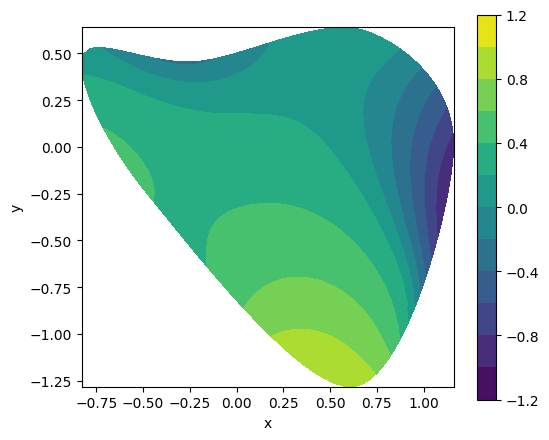

In [62]:
# np.random.seed(1)
l, mesh, points =  GenerateRandomSolution(n_min = 4, n_max = 8, elSize = 0.05, n_order = 3)

PlotFEMsolution(mesh['nodes'], mesh['elements'],l)
# plt.scatter(nodes[:,0],nodes[:,1],c='k',s=1)
nodes = mesh['nodes']
boundaryNodes = mesh['boundaryNodes']
points = mesh['points']
elements = mesh['elements']
alpha = mesh['alpha']

In [23]:
# Create the dataset
n_solutions = 10
dataset = []
for i in range(n_solutions):
    print(f'\n {i+1}/{n_solutions} \n')
    l, mesh,points =  GenerateRandomSolution(n_min = 4, n_max = 8, elSize = 0.05, n_order = 3)
    mesh['l'] = l
    mesh['points'] = points
    dataset.append(mesh)

Iteration 8; err = 8.213029389379848e-08
Iteration 9; err = 1.2238234066153555e-08
Iteration 10; err = 1.817984417878678e-09

 8/10 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpvl5ukr15/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpvl5ukr15/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0154257s, CPU 0.029017s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.047274s, CPU 0.089986s)
Info    : 1629 nodes 3251 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpvl5ukr15/meshFile.msh'...
Info    : Done writing '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpvl5ukr15/meshFile.msh'


Iteration 1; err = 0.020659601548103264
Iteration 2; err = 0.007444036062169542
Iteration 3; err = 0.0013042654860375028
Iteration 4; err = 0.0002372854363449211
Iteration 5; err = 3.6546284552706564e-05
Iteration 6; err = 8.119712291063185e-06
Iteration 7; err = 1.4324575810830925e-06
Iteration 8; err = 2.9620844226570014e-07
Iteration 9; err = 5.486140076113938e-08
Iteration 10; err = 1.0494409588491702e-08
Iteration 11; err = 2.106864405910443e-09

 9/10 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpx3par0wd/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpx3par0wd/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00705183s, CPU 0.013477s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.047739s, CPU 0.091083s)
Info    : 1736 nodes 3466 elements
Info    : Wr

Iteration 1; err = 0.029671544554743863
Iteration 2; err = 0.015402776701838641
Iteration 3; err = 0.004873068191556465
Iteration 4; err = 0.000799421499011345
Iteration 5; err = 0.00017233893853990382
Iteration 6; err = 3.991852088668587e-05
Iteration 7; err = 9.647370934274454e-06
Iteration 8; err = 2.588075672838972e-06
Iteration 9; err = 5.816296257475458e-07
Iteration 10; err = 1.4972232128301152e-07
Iteration 11; err = 3.5684621507942246e-08
Iteration 12; err = 8.695992471028436e-09

 10/10 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmprmkxzujd/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmprmkxzujd/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0122886s, CPU 0.025064s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0193572s, CPU 0.037004s)
Info   

Iteration 1; err = 0.02816114742145489
Iteration 2; err = 0.00982934703721613
Iteration 3; err = 0.0014357002766140427
Iteration 4; err = 0.0003143661153458973
Iteration 5; err = 3.854805927376128e-05
Iteration 6; err = 1.0470111763846751e-05
Iteration 7; err = 1.5610579275424752e-06
Iteration 8; err = 3.4867379086753384e-07
Iteration 9; err = 6.256896722501247e-08
Iteration 10; err = 1.1119993018728243e-08
Iteration 11; err = 2.462028049509049e-09


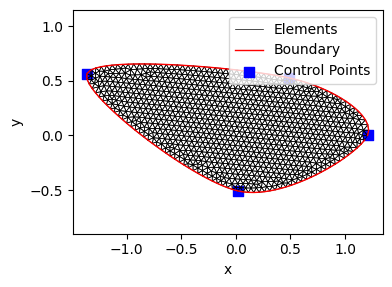

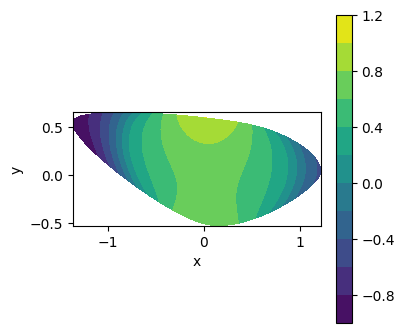

In [67]:
def PlotMesh2(nodes, boundaryNodes, elements,lineWidth=1):
    # plt.scatter(nodes[:,0],nodes[:,1])
    if elements.shape[1] == 4:
        for el in elements:
            plt.plot(nodes[[el[0],el[1],el[3],el[2],el[0]],0], nodes[[el[0],el[1],el[3],el[2],el[0]],1], 'k',linewidth=lineWidth)
    elif elements.shape[1] == 3:
        for i,el in enumerate(elements):
            if i == 0:
                plt.plot(nodes[[el[0],el[1],el[2],el[0]],0], nodes[[el[0],el[1],el[2],el[0]],1], 'k',linewidth=lineWidth,label='Elements')
            else:
                plt.plot(nodes[[el[0],el[1],el[2],el[0]],0], nodes[[el[0],el[1],el[2],el[0]],1], 'k',linewidth=lineWidth)
    plt.plot(nodes[boundaryNodes,0],nodes[boundaryNodes,1],'r',linewidth=2*lineWidth,label='Boundary')
    plt.gca().set_aspect('equal', adjustable='box')
    # plt.show()

def PlotFEMsolution2(nodes, elements,l):
    if elements.shape[1] == 4:
        # Convert quadrlateral mesh to triangular mesh
        elements = np.concatenate([elements[:,:3],elements[:,1:]],0)

    # Create a Triangulation object
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)

    # Plotting
    plt.tricontourf(triangulation, l[:,0],10)
    plt.colorbar()
    # plt.scatter(nodes[:,0],nodes[:,1],s=1,c='k')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal', adjustable='box')
    return

# plt.figure(figsize=(10,7),dpi=300)
# idxs = [0,4]
# i=0
# idx = idxs[i]
# plt.subplot(2,2,i+1)
# PlotMesh2(dataset[idx]['nodes'], dataset[idx]['boundaryNodes'], dataset[idx]['elements'], lineWidth=0.5)
# plt.scatter(dataset[idx]['points'][:,0],dataset[idx]['points'][:,1],marker='s',c='b',s=50,label='Control Points')
# plt.legend()
# plt.subplot(2,2,i+3)
# PlotFEMsolution2(dataset[idx]['nodes'], dataset[idx]['elements'],dataset[idx]['l'])

# i=1
# idx = idxs[i]
# plt.subplot(2,2,i+1)
# PlotMesh2(dataset[idx]['nodes'], dataset[idx]['boundaryNodes'], dataset[idx]['elements'], lineWidth=0.5)
# plt.scatter(dataset[idx]['points'][:,0],dataset[idx]['points'][:,1],marker='s',c='b',s=50,label='Control Points')
# plt.ylim(-0.5,0.85)
# plt.legend()
# plt.subplot(2,2,i+3)
# PlotFEMsolution2(dataset[idx]['nodes'], dataset[idx]['elements'],dataset[idx]['l'])


# plt.figure(figsize=(10,7))
# plt.subplot(2,3,1)
# PlotMesh2(nodes, boundaryNodes, elements, lineWidth=1)
# plt.scatter(points[:,0],points[:,1],marker='s',c='b',s=100,label='Control Points')
# plt.legend()

plt.figure(figsize=(4,4),dpi=100)
idx = 5
PlotMesh2(dataset[idx]['nodes'], dataset[idx]['boundaryNodes'], dataset[idx]['elements'], lineWidth=0.5)
plt.scatter(dataset[idx]['points'][:,0],dataset[idx]['points'][:,1],marker='s',c='b',s=50,label='Control Points')
plt.legend()
# plt.ylim(-1.1,0.5)
# plt.ylim(-0.5,0.85)
plt.ylim(-0.9,1.15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()
plt.figure(figsize=(4,4),dpi=100)
PlotFEMsolution2(dataset[idx]['nodes'], dataset[idx]['elements'],dataset[idx]['l'])
plt.show()

In [ ]:
def ConvertDictNP2List(d):
    for key in d.keys():
        d[key] = d[key].tolist()
    return d

# Create the dataset
n_solutions = 100
dataset = []
for i in range(n_solutions):
    print(f'\n {i+1}/{n_solutions} \n')
    l, mesh,points =  GenerateRandomSolution(n_min = 4, n_max = 8, elSize = 0.05, n_order = 3)
    mesh['l'] = l
    dataset.append(ConvertDictNP2List(mesh))

In [439]:
with open('TrainingData/NLheatDataset.json', 'w') as fp:
    json.dump(dataset, fp)

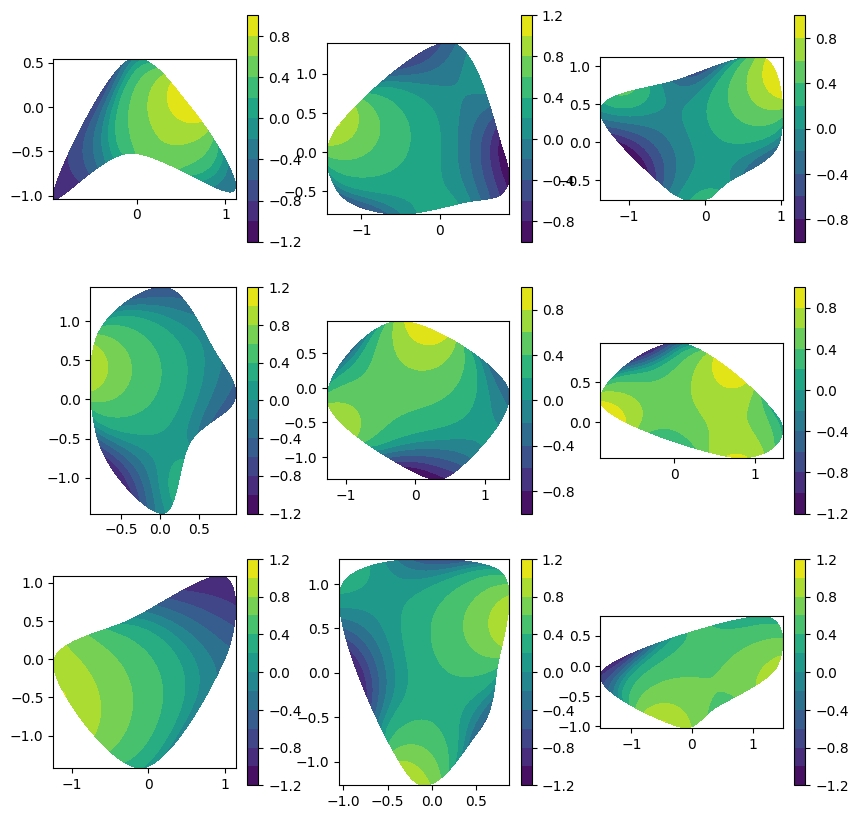

In [444]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    elements = np.array(dataset[i+9]['elements'])
    nodes = np.array(dataset[i+9]['nodes'])
    l = np.array(dataset[i+9]['l'])

    # Create a Triangulation object
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)

    # Plotting
    plt.tricontourf(triangulation, l[:,0],10)
    plt.colorbar()
    plt.gca().set_aspect('equal', adjustable='box')

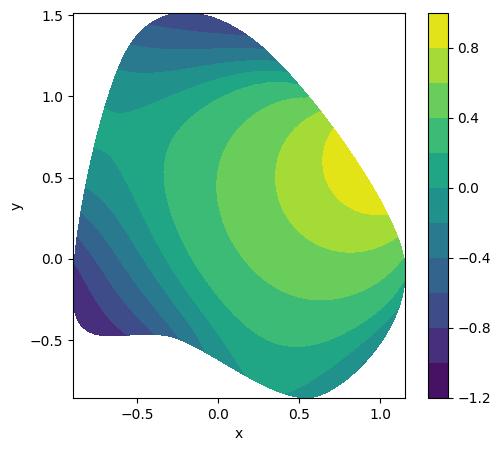

In [440]:
solution = dataset[2]
PlotFEMsoluttionDict(solution)

Iteration 1; err = 0.02700666163094086
Iteration 2; err = 0.011040715339435021
Iteration 3; err = 0.0031492805199655424
Iteration 4; err = 0.0006046213746053647
Iteration 5; err = 7.824732166036742e-05
Iteration 6; err = 2.6529835217363227e-05
Iteration 7; err = 4.577933074487054e-06
Iteration 8; err = 1.1751486244661872e-06
Iteration 9; err = 2.9111508264641873e-07
Iteration 10; err = 4.364217155540716e-08
Iteration 11; err = 1.6227922444304482e-08
Iteration 12; err = 2.040980627512531e-09


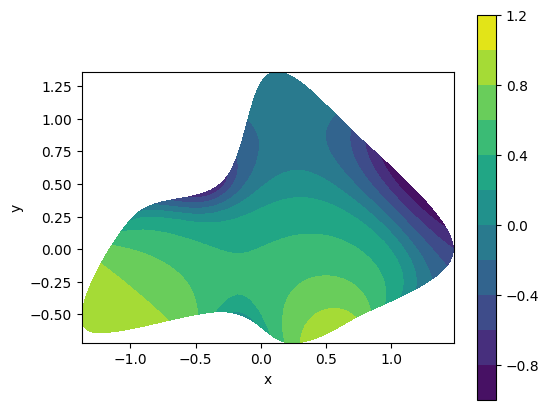

In [238]:
# A11 = np.array([[1,0],[0,1]])
# A12 = np.array([[0,0],[0,0]])
# A22 = np.array([[1,0.5],[0.5,1]])
# A = np.concatenate([
#     np.concatenate([A11,A12],axis=1),
#     np.concatenate([A12,A22],axis=1)
# ],axis=0)
# r=2


A = lambda u: np.concatenate([
    np.concatenate([[[10*np.max([u.mean(),0])**2+0.5]],[[0]]],axis=1),
    np.concatenate([[[0]],[[10*np.max([u.mean(),0])**2+0.5]]],axis=1)
],axis=0)
A_lin = A(np.array([0]))
r = 1

# Define Dirichlet BC
# n_order = 3
# p = np.random.randn(2,n_order,r)
# BCfunc_unscaled = lambda alpha: np.array([[p[0,j,i]*np.cos((j+1)*alpha) + p[1,j,i]*np.sin((j+1)*alpha) for i in range(r)] for j in range(n_order)]).T.sum(axis=-1)
# alpha = np.linspace(0,2*np.pi,100)
# vals = BCfunc_unscaled(alpha)
# vals_max = np.max(vals)
# vals_min = np.min(vals)
# BCfunc = lambda alpha: (BCfunc_unscaled(alpha)-vals_min)/(vals_max-vals_min)*2-1

internalNodes = np.setdiff1d(np.arange(nodes.shape[0]), boundaryNodes)
l_lin = SolveFEM(nodes, elements, boundaryNodes, BCfunc, internalNodes, r, A_lin, A_nl=False, l=None)
l,iters = SolveFEM_itt(nodes, elements, boundaryNodes, BCfunc, internalNodes, r, A, tol=1e-8,show_err=True, max_iter=20)
triangulation = PlotFEMsolution(nodes, elements,l)

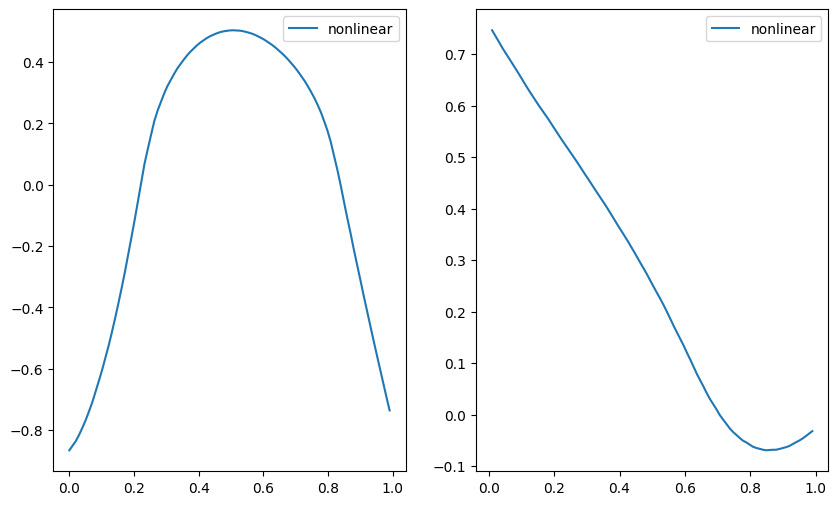

In [347]:
interp = LinearNDInterpolator(nodes, l)
# interp_lin = LinearNDInterpolator(nodes, l_lin)
scaler = np.linspace(0,1,100).reshape(-1,1)
n = points.shape[0]//2
n_2 = points.shape[0]//4
points_line1 = (points[0:1,:]*(1-scaler)+points[n:n+1,:]*scaler)
points_line2 = (points[n_2:n_2+1,:]*(1-scaler)+points[n_2+n:n_2+n+1,:]*scaler)
z1 = interp(points_line1)
# z1_lin = interp_lin(points_line1)
z2 = interp(points_line2)
# z2_lin = interp_lin(points_line2)
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(scaler,z1[:,:],label='nonlinear')
# plt.plot(scaler,z1_lin[:,:],label='linear')
plt.legend()
plt.subplot(1,2,2)
plt.plot(scaler,z2[:,:],label='nonlinear')
# plt.plot(scaler,z2_lin[:,:],label='linear')
plt.legend()

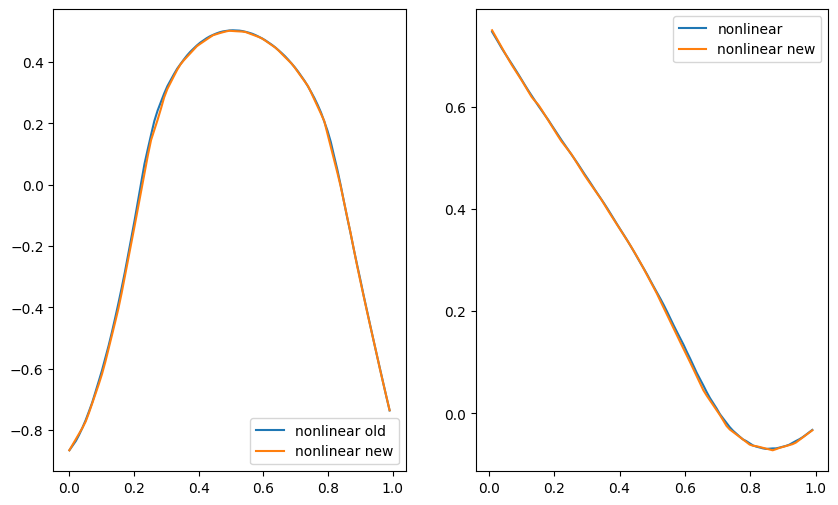

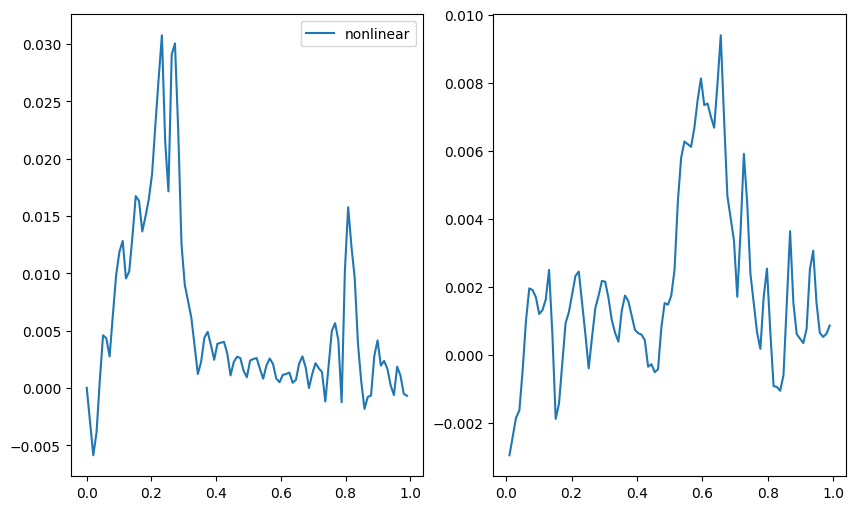

In [350]:
interp = LinearNDInterpolator(nodes, l)
# interp_lin = LinearNDInterpolator(nodes, l_lin)
z1_new = interp(points_line1)
# z1_lin_new = interp_lin(points_line1)
z2_new = interp(points_line2)
# z2_lin_new = interp_lin(points_line2)
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(scaler,z1[:,:],label='nonlinear old')
# plt.plot(scaler,z1_lin[:,:],label='linear old')
plt.plot(scaler,z1_new[:,:],label='nonlinear new')
# plt.plot(scaler,z1_lin_new[:,:],label='linear new')
plt.legend()
plt.subplot(1,2,2)
plt.plot(scaler,z2[:,:],label='nonlinear')
# plt.plot(scaler,z2_lin[:,:],label='linear')
plt.plot(scaler,z2_new[:,:],label='nonlinear new')
# plt.plot(scaler,z2_lin_new[:,:],label='linear new')
plt.legend()

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(scaler,z1[:,:]-z1_new[:,:],label='nonlinear')
# plt.plot(scaler,z1_lin[:,:]-z1_lin_new[:,:],label='linear')
plt.legend()
plt.subplot(1,2,2)
plt.plot(scaler,z2[:,:]-z2_new[:,:],label='nonlinear')
# plt.plot(scaler,z2_lin[:,:]-z2_lin_new[:,:],label='linear')

In [93]:
import os
import json
num = '10'

historyPath = f'Models/LaplaceNL_FEM/model_1_{num}/history.json'
hyperParamsPath  = f'Models/LaplaceNL_FEM/model_1_{num}/hyperParams.json'

with open(historyPath, 'r') as fp:
    history = json.load(fp)

with open(hyperParamsPath, 'r') as fp:
    hyperParams = json.load(fp)

In [110]:
print(np.mean(history['err_test'][idx:]))
print(np.std(history['err_test'][idx:]))

2.5593696834702923e-05
6.903200281647207e-06


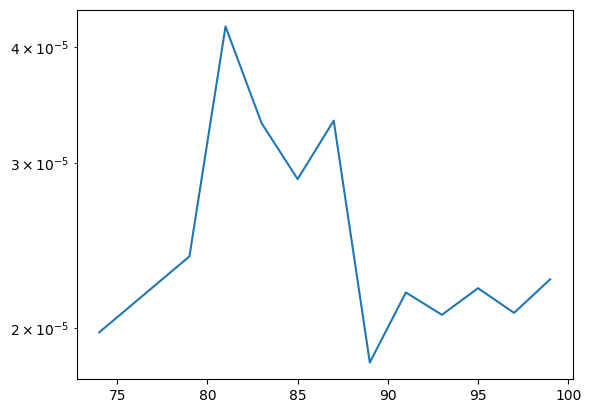

In [109]:
idx = 14
plt.plot(history['err_epoch'][idx:], history['err_test'][idx:])
plt.gca().set_yscale('log')